Load dependencies

In [3]:
import scanpy as sc
import anndata as ad
import pandas as pd
import phate

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

Set settings and constants.

In [4]:
sc.settings.set_figure_params(dpi=50, facecolor="white")
DATA_DIR = '/data/BIOL5177/Assessment'
SAMPLES = ['Infected1','Infected2','WT1']

Load in the data

In [5]:
# Returns an AnnData object which contains all the experiment data for analysis from csv files
def load_count_data_csv(data_dir, samples, counts_matrix = 'counts_matrix.csv', metadata = 'metadata.csv'):
    adata_dict = {}
    # iterate over the different samples
    for sample_id in samples:
        # Create AnnData object for sample
        filepath = f'{data_dir}/{sample_id}/{counts_matrix}'
        counts_adata = sc.read(filepath)
        # Transpose the data 
        counts_adata = counts_adata.transpose()
        # Make sure genes are unique
        counts_adata.var_names_make_unique()

        # Add to dict    
        adata_dict[sample_id] = counts_adata
    
    # Concatenate all data into one AnnData object
    adata = ad.concat(adata_dict, label="sample")
    
    return adata

    
    #return adata_dict


adata = load_count_data_csv(DATA_DIR, SAMPLES)


Calculate QC metrics

In [6]:
# Identify Mitocondrial cells
adata.var["mt"] = adata.var_names.str.startswith("Mt")
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata,qc_vars=["mt"], inplace=True, log1p=True)

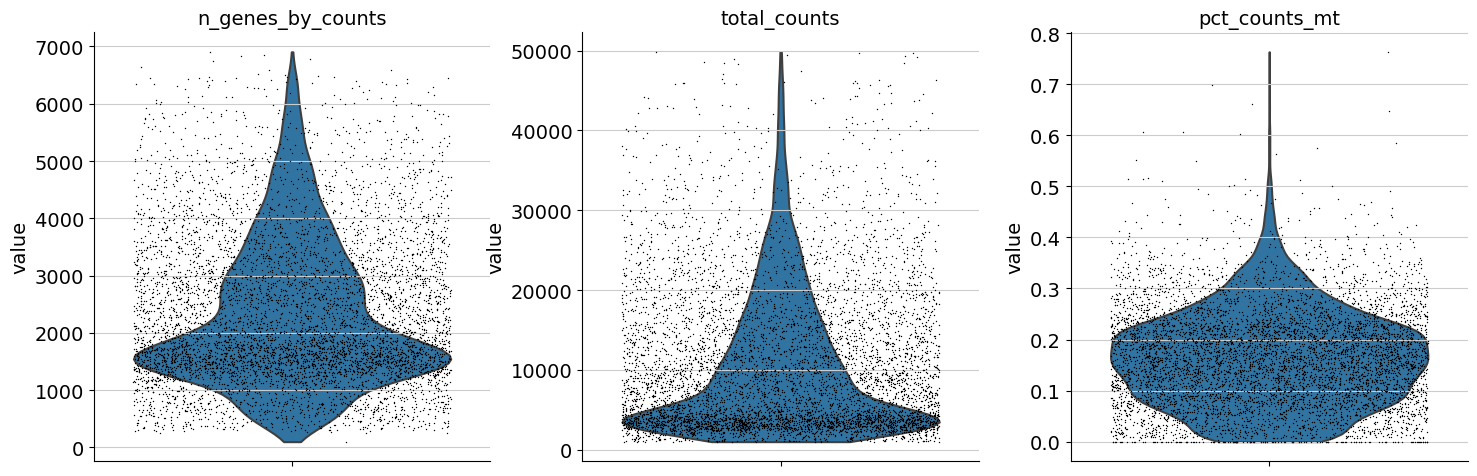

In [8]:
# Create violin plots for various QC metrics
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    save='_qc.pdf'
)

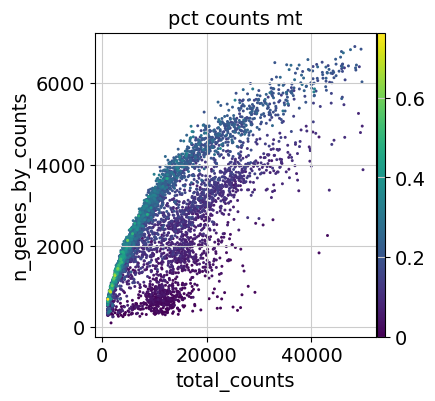

In [10]:
# Create a scatter plot of QC metrics
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Filter data to cells with between 100-2500 genes and genes with a at least 3 cells

In [11]:
# Filters data according min and max genes for cells and min cells for genes
def qc_filters(adata, min_genes=100, max_genes=2500, min_cells=3):
    sc.pp.filter_cells(adata, min_genes=100)
    sc.pp.filter_cells(adata, max_genes=2500)
    sc.pp.filter_genes(adata, min_cells=3)
    return adata

adata = qc_filters(adata)

Normalise and logarithmize count data

In [12]:
def normalise_data(adata):
    adata.layers["counts"] = adata.X.copy()
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize
    sc.pp.log1p(adata)
    return adata

adata = normalise_data(adata)

Feature selection,  select the most highly variable genes for further analysis

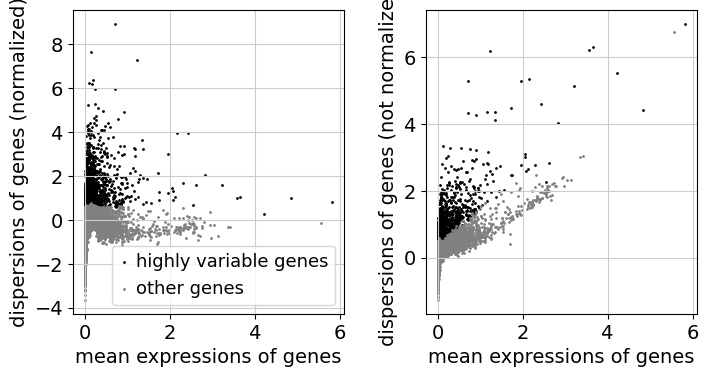

In [13]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")
sc.pl.highly_variable_genes(adata)

Scale data

In [14]:
sc.pp.scale(adata)

PCA

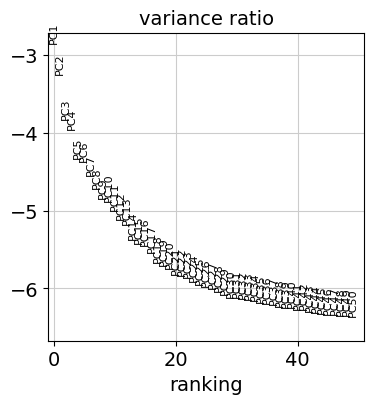

In [15]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

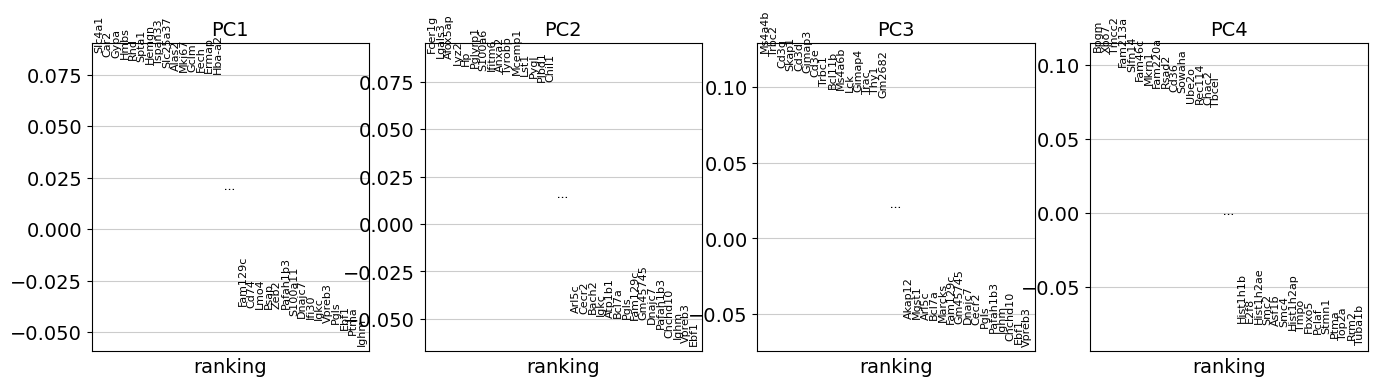

/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


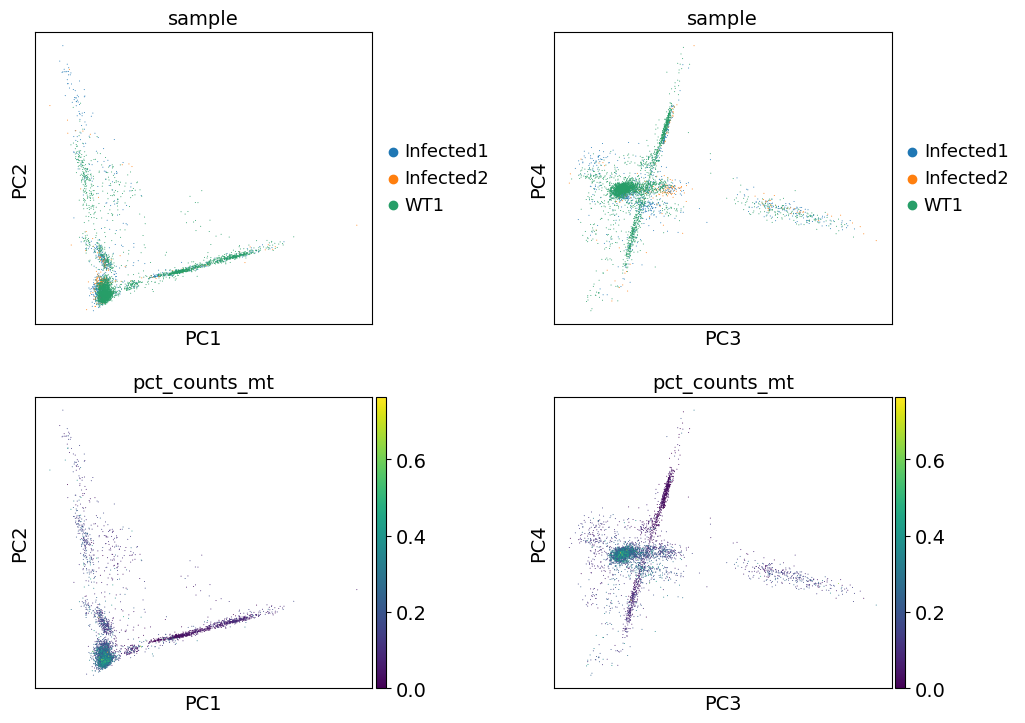

In [16]:
sc.pl.pca_loadings(adata, components = '1,2,3,4',save='.pdf')
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
    wspace=0.4,
    return_fig=True
).savefig('./figures/pca_scatter.pdf', bbox_inches='tight')

UMAP

/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


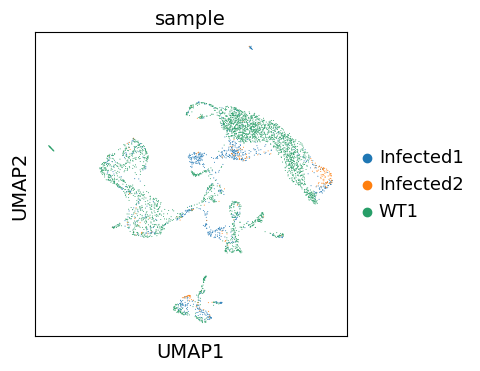

In [ ]:
# Create a copy of adata for the un-integrated UMAP
uninter_adata = adata.copy()

# Carries out a UMAP and outputs a scatter plot. 
def run_umap(adata, fig_filepath, n_pcs=None, use_rep=None):
    # Compute a nearest neighbours graph
    sc.pp.neighbors(adata, n_pcs=n_pcs, use_rep=use_rep)
    # Embed the graph with UMAP
    sc.tl.umap(adata)
    # Plot a scatter plot of the umap
    sc.pl.umap(
        adata,
        color="sample",
        size=2,
        return_fig=True
    ).savefig(fig_filepath, bbox_inches='tight')

# Run UMAP on unitegrated data
run_umap(uninter_adata,'./figures/umap.pdf', n_pcs=28)

Integration with scanpy

In [ ]:
adata_integrated = adata.copy()
sc.external.pp.scanorama_integrate(adata_integrated, "sample")


[[0.         0.89552239 0.81052632]
 [0.         0.         0.59701493]
 [0.         0.         0.        ]]
Processing datasets Infected1 <=> Infected2
Processing datasets Infected1 <=> WT1
Processing datasets Infected2 <=> WT1


In [ ]:
#type(adata_integrated_b)
#adata_integrated_b.obs
#adata_integrated.obsm

,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_genes
TTCCTAACACGCTGCA_4,Infected1,2471,7.812783,13837.0,9.535173,56.457325,61.993207,68.844403,79.330780,18.0,2.944439,0.130086,2471
CCATAAGAGCTTTCTT_4,Infected1,497,6.210600,2018.0,7.610358,71.308226,77.403370,85.282458,100.000000,2.0,1.098612,0.099108,497
CTCATTATCGCCGAGT_4,Infected1,1535,7.336937,3369.0,8.122668,26.832888,38.082517,49.688335,68.774117,8.0,2.197225,0.237459,1535
CGAGTTATCCGTCACT_4,Infected1,1338,7.199678,12915.0,9.466222,80.952381,83.724352,87.193186,92.938444,4.0,1.609438,0.030972,1338
GGGTCTGCATCGAAGG_4,Infected1,2456,7.806696,6352.0,8.756682,22.654282,33.517003,44.537154,61.224811,22.0,3.135494,0.346348,2456
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATGGATCGTTGTTGTG_6,WT1,591,6.383507,7904.0,8.975251,87.892206,90.928644,94.268725,98.848684,2.0,1.098612,0.025304,591
CGCATAACAGGCTATT_6,WT1,1633,7.398786,3617.0,8.193677,30.467238,40.088471,50.207354,68.122754,6.0,1.945910,0.165883,1633
GGAGGATGTAGTGTGG_6,WT1,1491,7.307873,3349.0,8.116715,27.948641,39.235593,51.209316,70.409077,4.0,1.609438,0.119439,1491
TCCGATCTCATTTCGT_6,WT1,1521,7.327781,3131.0,8.049427,27.147876,36.889173,48.323219,67.390610,9.0,2.302585,0.287448,1521


/software/Anaconda3-2023.03/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


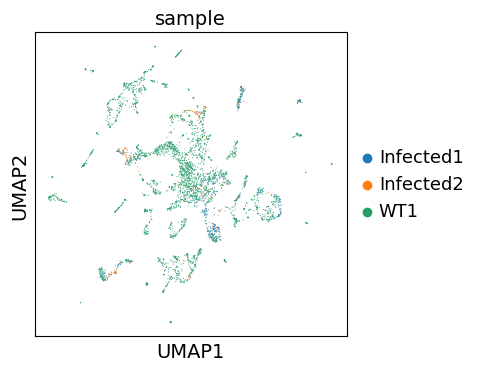

In [119]:
#print(adata_integrated)
#adata.obsm['X_scanorama']

#sc.pp.neighbors(adata_integrated, use_rep="X_scanorama")
#sc.tl.umap(adata_integrated)
#sc.pl.umap(
#    adata_integrated,
#    color="sample",
#    size=2,
#    return_fig=True
#).savefig('./plots/i_umap.pdf', bbox_inches='tight')

run_umap(adata_integrated,'./plots/i_umap.pdf', use_rep="X_scanorama")

Clustering

/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


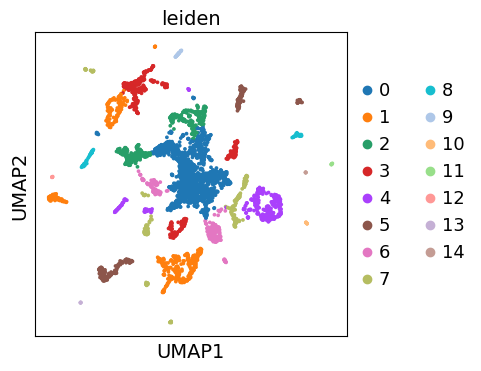

In [120]:
sc.tl.leiden(adata_integrated, resolution=0.1, n_iterations=-1) #sc.tl.leiden(adata_integrated, resolution=0.044, n_iterations=-1)
sc.pl.umap(adata_integrated, color=["leiden"], return_fig=True).savefig('./plots/i_umap_clusters.pdf', bbox_inches='tight')

/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.l

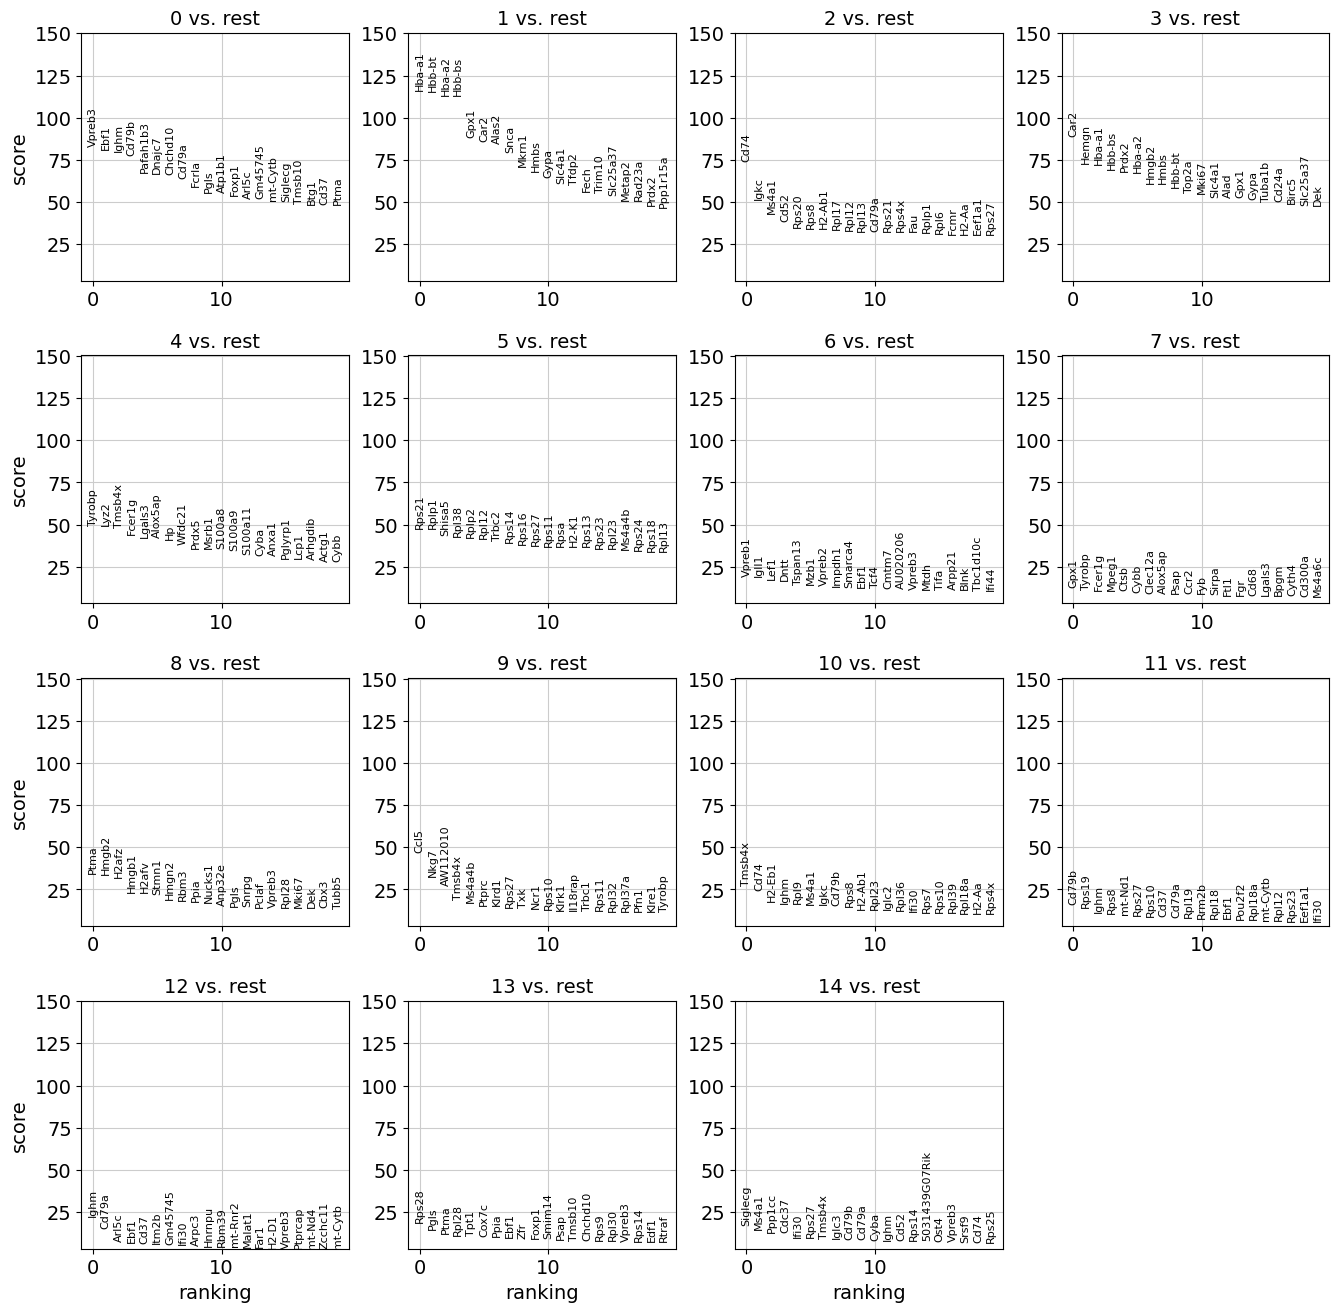

In [121]:
sc.tl.rank_genes_groups(adata_integrated, 'leiden')
sc.pl.rank_genes_groups(adata_integrated, save = 'markers.pdf') #.savefig('./markers.pdf', bbox_inches='tight')
#adata_integrated.obs

In [163]:
#adata_integrated.obs["cell_type"] = adata_integrated.obs["leiden"]
adata_integrated.obs["cell_type"] = adata_integrated.obs["leiden"].map(
    {
        "0": "0 B Cells",
        "1": "1 Erythroid",
        "2": "2 B Cells",
        "3": "3",
        "4": "4",
        "5": "5",
        "6": "6",
        "7": "7",
        "8": "8",
        "9": "9",
        "10": "10",
        "11": "11",
        "12": "12",
        "13": "13",
        "14": "14"
        
    },na_action='ignore'
)

In [ ]:
"3": "3",
        "4": "4",
        "5": "5",
        "6": "6",
        "7": "7",
        "8": "8",
        "9": "9",
        "10": "10",
        "11": "11",
        "12": "12",
        "13": "13",
        "14": "14,

In [162]:
adata_integrated.obs

,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_genes,leiden,cell_type
TTCCTAACACGCTGCA_4,Infected1,2471,7.812783,13837.0,9.535173,56.457325,61.993207,68.844403,79.330780,18.0,2.944439,0.130086,2471,4,4
CCATAAGAGCTTTCTT_4,Infected1,497,6.210600,2018.0,7.610358,71.308226,77.403370,85.282458,100.000000,2.0,1.098612,0.099108,497,1,1 Erythroid
CTCATTATCGCCGAGT_4,Infected1,1535,7.336937,3369.0,8.122668,26.832888,38.082517,49.688335,68.774117,8.0,2.197225,0.237459,1535,0,0 B Cells Cluster
CGAGTTATCCGTCACT_4,Infected1,1338,7.199678,12915.0,9.466222,80.952381,83.724352,87.193186,92.938444,4.0,1.609438,0.030972,1338,1,1 Erythroid
GGGTCTGCATCGAAGG_4,Infected1,2456,7.806696,6352.0,8.756682,22.654282,33.517003,44.537154,61.224811,22.0,3.135494,0.346348,2456,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATGGATCGTTGTTGTG_6,WT1,591,6.383507,7904.0,8.975251,87.892206,90.928644,94.268725,98.848684,2.0,1.098612,0.025304,591,1,1 Erythroid
CGCATAACAGGCTATT_6,WT1,1633,7.398786,3617.0,8.193677,30.467238,40.088471,50.207354,68.122754,6.0,1.945910,0.165883,1633,0,0 B Cells Cluster
GGAGGATGTAGTGTGG_6,WT1,1491,7.307873,3349.0,8.116715,27.948641,39.235593,51.209316,70.409077,4.0,1.609438,0.119439,1491,0,0 B Cells Cluster
TCCGATCTCATTTCGT_6,WT1,1521,7.327781,3131.0,8.049427,27.147876,36.889173,48.323219,67.390610,9.0,2.302585,0.287448,1521,0,0 B Cells Cluster


/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


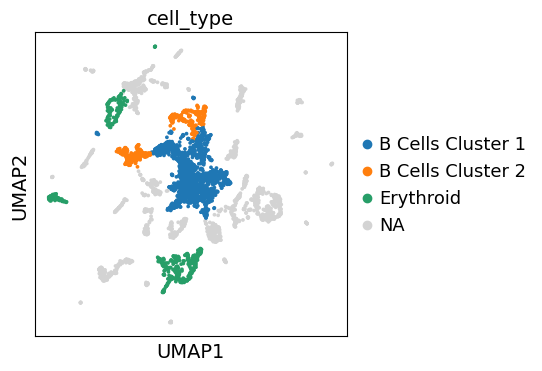

In [124]:
#adata_integrated.obs
#type(adata_integrated.obs["leiden"])
sc.pl.umap(adata_integrated, color=["cell_type"], return_fig=True).savefig('./plots/i_umap_cells.pdf', bbox_inches='tight')

DE

In [ ]:
# Get the cluster containing Ms4a1
b_cells_adata = adata_integrated[adata_integrated.obs['cell_type'] == 'B Cells Cluster 2',:]
b_cells_adata.obs['sample_type'] = b_cells_adata.obs['sample'].map({
        "WT1": "WT",
        "Infected1": "Infected",
        "Infected2": "Infected",
        
    },)

/tmp/ipykernel_1652785/4253382734.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  b_cells_adata.obs['sample_type'] = b_cells_adata.obs['sample'].map({


/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


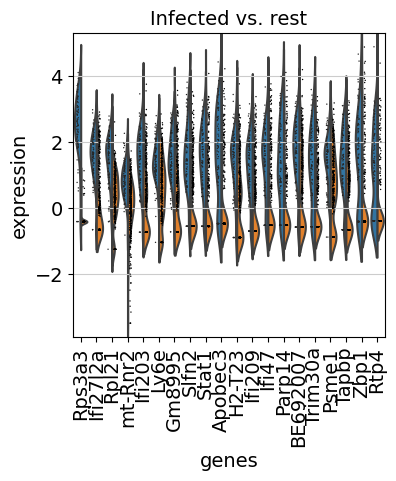

/software/Anaconda3-2023.03/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


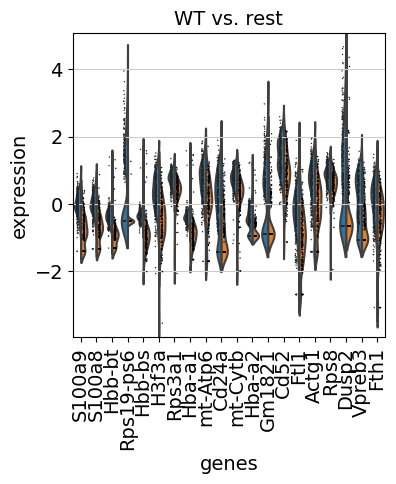

In [129]:
sc.tl.rank_genes_groups(b_cells_adata, 'sample_type')
sc.pl.rank_genes_groups_violin(b_cells_adata, save = '_VDE.pdf')

Harmony integration

In [130]:
adata_integrated_harmony = adata.copy()
sc.external.pp.harmony_integrate(adata_integrated_harmony, "sample")

2025-04-06 18:45:38,132 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-04-06 18:45:57,512 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-06 18:45:57,628 - harmonypy - INFO - Iteration 1 of 10
2025-04-06 18:46:06,052 - harmonypy - INFO - Iteration 2 of 10
2025-04-06 18:46:11,400 - harmonypy - INFO - Iteration 3 of 10
2025-04-06 18:46:17,634 - harmonypy - INFO - Iteration 4 of 10
2025-04-06 18:46:23,375 - harmonypy - INFO - Iteration 5 of 10
2025-04-06 18:46:27,514 - harmonypy - INFO - Iteration 6 of 10
2025-04-06 18:46:32,095 - harmonypy - INFO - Iteration 7 of 10
2025-04-06 18:46:36,983 - harmonypy - INFO - Iteration 8 of 10
2025-04-06 18:46:40,227 - harmonypy - INFO - Iteration 9 of 10
2025-04-06 18:46:42,712 - harmonypy - INFO - Iteration 10 of 10
2025-04-06 18:46:45,657 - harmonypy - INFO - Stopped before convergence


/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


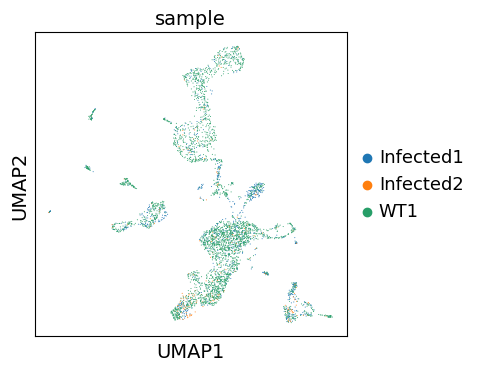

In [132]:
run_umap(adata_integrated_harmony,'./plots/harmony_i_umap.pdf', use_rep="X_pca_harmony")

Clustering

/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


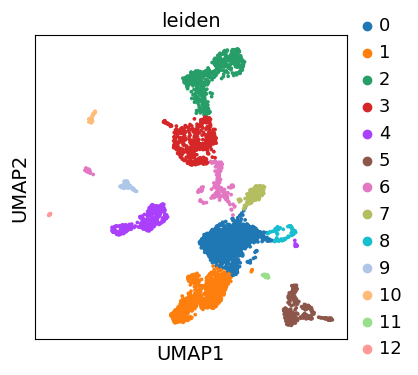

In [136]:
sc.tl.leiden(adata_integrated_harmony, resolution=0.2, n_iterations=-1) #sc.tl.leiden(adata_integrated, resolution=0.044, n_iterations=-1)
sc.pl.umap(adata_integrated_harmony, color=["leiden"], return_fig=True).savefig('./plots/harmony_i_umap_clusters.pdf', bbox_inches='tight')

/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.l

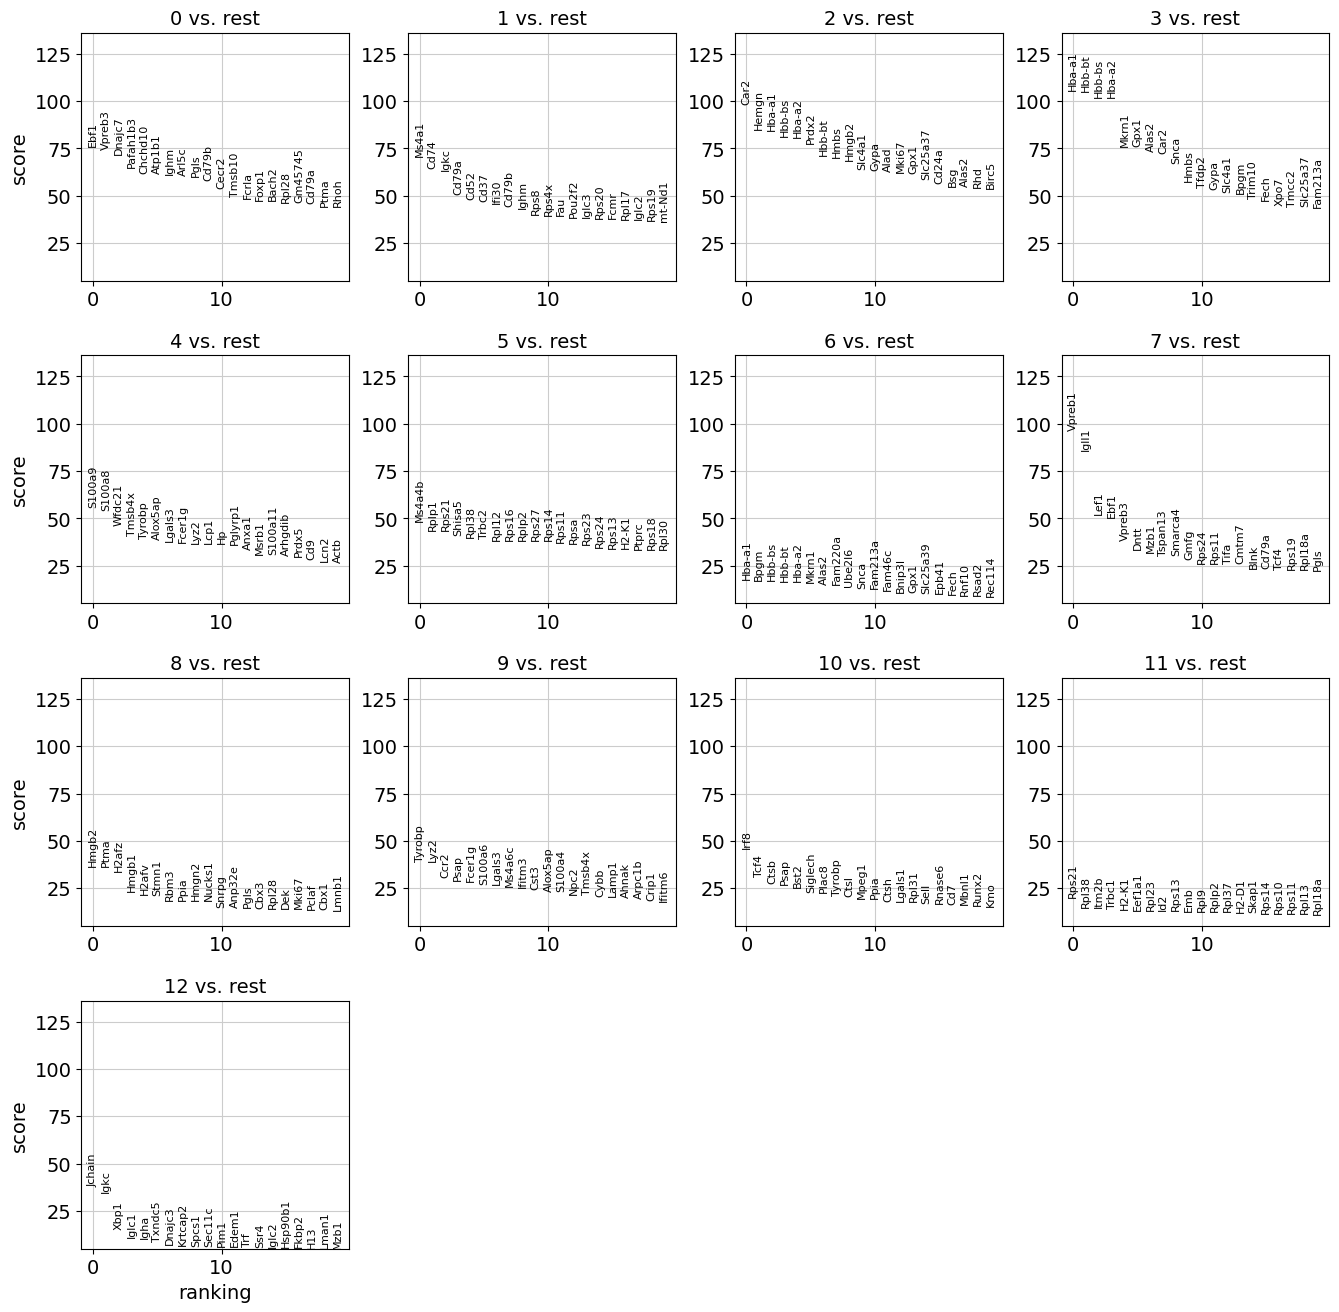

In [137]:
sc.tl.rank_genes_groups(adata_integrated_harmony, 'leiden')
sc.pl.rank_genes_groups(adata_integrated_harmony, save = '_harmony.pdf')

In [145]:
b_cells_adata_harmony = adata_integrated_harmony[adata_integrated_harmony.obs['leiden'] == '1',:]
b_cells_adata_harmony.obs['sample_type'] = b_cells_adata_harmony.obs['sample'].map({
        "WT1": "WT",
        "Infected1": "Infected",
        "Infected2": "Infected",
        
    },)

/tmp/ipykernel_1652785/3646125944.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  b_cells_adata_harmony.obs['sample_type'] = b_cells_adata_harmony.obs['sample'].map({


/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


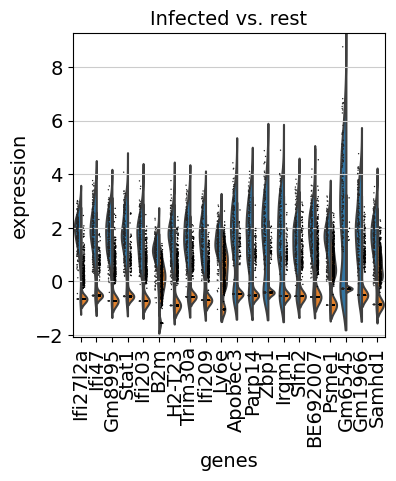

/software/Anaconda3-2023.03/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


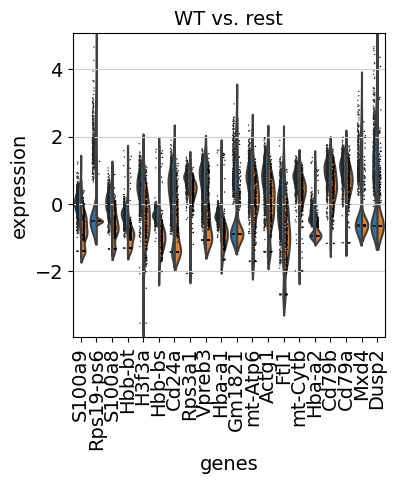

In [146]:
sc.tl.rank_genes_groups(b_cells_adata_harmony, 'sample_type')
sc.pl.rank_genes_groups_violin(b_cells_adata_harmony, save = '_harmony_VDE.pdf')

Pseudobulk

In [265]:
#sc.get.aggregate(b_cells_adata, by=["sample", "cell_type"], func="sum", layer="counts")
def pseudobulk_samples(adata):
    genes = adata.var_names
    samples = adata.obs['sample'].unique()
    
    sample_types = adata.obs['sample_type'].unique()
    pseudobulk_df = pd.DataFrame(0, samples, genes)

    metadata = pd.DataFrame('NA', samples, columns=['sample_type'])
    

    for sample in samples:
        for sample_type in sample_types:
            if sample.startswith(sample_type):
                metadata['sample_type'][sample] = sample_type

        sample_adata = adata[adata.obs['sample']==sample]
        counts = sum(sample_adata.layers['counts'])

        for i in range(len(genes)):
            pseudobulk_df[genes[i]][sample] = counts[i]

    return pseudobulk_df, metadata

b_cells_pseudobulk, metadata = pseudobulk_samples(b_cells_adata)
metadata

#b_cells_pseudobulk
#b_cells_adata
#b_cells_adata.var['mean'] = ['sample_type']
#b_cells_adata['ATCCGTCGTTGGGTAG_4'].var

#for sample_type in b_cells_adata.obs['sample_type'].unique():
#    b_cells_adata.var[f'{sample_type}_meancount'] = 

#b_cells_adata.var['n_cells']

,sample_type
Infected1,Infected
Infected2,Infected
WT1,WT


In [253]:
#b_cells_adata['ATCCGTCGTTGGGTAG_4'].layers['counts']
i = 0
for gene in b_cells_adata[b_cells_adata.obs['sample_type']=='WT'].layers['counts']:
    #print(len(gene))
    i += 1
    if i > 4:
        break
     #['Mrpl15']
#b_cells_adata.obs['sample_type'=='`WT']
test_genes = b_cells_adata.var_names
test_types = b_cells_adata.obs['sample_type'].unique()
test_df = pd.DataFrame(0, test_genes, test_types)
type(test_df['WT']['Mrpl15'])

numpy.int64

In [ ]:
test = b_cells_adata[b_cells_adata.obs['sample_type']=='WT']
print(type(s(sum(test.layers['counts']))))
pd.Series(sum(test.layers['counts']))

<class 'pandas.core.series.Series'>


0         58.0
1          0.0
2         48.0
3        155.0
4         46.0
         ...  
17379      0.0
17380      0.0
17381      1.0
17382      0.0
17383      0.0
Length: 17384, dtype: float32

Trajectory analysis

/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


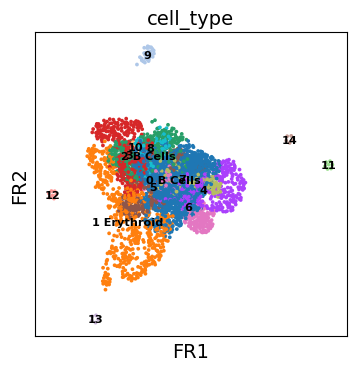

In [179]:
# use the umap to initialize the graph layout.
sc.tl.draw_graph(adata_integrated, init_pos='X_umap')
sc.pl.draw_graph(adata_integrated, color='cell_type', legend_loc='on data', legend_fontsize = 'xx-small',return_fig=True).savefig('./plots/umap_traj.pdf', bbox_inches='tight')


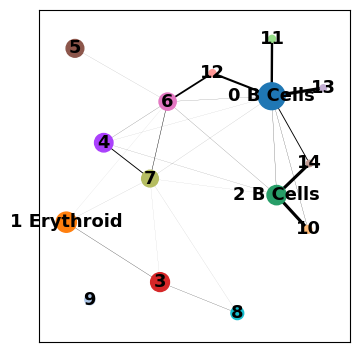

In [ ]:
sc.tl.paga(adata_integrated, groups='cell_type')
sc.pl.paga(adata_integrated, color='cell_type', edge_width_scale = 0.3,return_fig=True).savefig('./plots/paga.pdf', bbox_inches='tight')

PHATE

In [173]:
sc.external.tl.phate(adata_integrated, k=5, a=20, t=150)

/software/Anaconda3-2023.03/lib/python3.10/site-packages/phate/phate.py:186: FutureWarning: k is deprecated. Please use knn in future.
  warnings.warn("k is deprecated. Please use knn in future.", FutureWarning)
/software/Anaconda3-2023.03/lib/python3.10/site-packages/phate/phate.py:190: FutureWarning: a is deprecated. Please use decay in future.
  warnings.warn("a is deprecated. Please use decay in future.", FutureWarning)


In [175]:
adata_integrated.obs

,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_genes,leiden,cell_type
TTCCTAACACGCTGCA_4,Infected1,2471,7.812783,13837.0,9.535173,56.457325,61.993207,68.844403,79.330780,18.0,2.944439,0.130086,2471,4,4
CCATAAGAGCTTTCTT_4,Infected1,497,6.210600,2018.0,7.610358,71.308226,77.403370,85.282458,100.000000,2.0,1.098612,0.099108,497,1,1 Erythroid
CTCATTATCGCCGAGT_4,Infected1,1535,7.336937,3369.0,8.122668,26.832888,38.082517,49.688335,68.774117,8.0,2.197225,0.237459,1535,0,0 B Cells
CGAGTTATCCGTCACT_4,Infected1,1338,7.199678,12915.0,9.466222,80.952381,83.724352,87.193186,92.938444,4.0,1.609438,0.030972,1338,1,1 Erythroid
GGGTCTGCATCGAAGG_4,Infected1,2456,7.806696,6352.0,8.756682,22.654282,33.517003,44.537154,61.224811,22.0,3.135494,0.346348,2456,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATGGATCGTTGTTGTG_6,WT1,591,6.383507,7904.0,8.975251,87.892206,90.928644,94.268725,98.848684,2.0,1.098612,0.025304,591,1,1 Erythroid
CGCATAACAGGCTATT_6,WT1,1633,7.398786,3617.0,8.193677,30.467238,40.088471,50.207354,68.122754,6.0,1.945910,0.165883,1633,0,0 B Cells
GGAGGATGTAGTGTGG_6,WT1,1491,7.307873,3349.0,8.116715,27.948641,39.235593,51.209316,70.409077,4.0,1.609438,0.119439,1491,0,0 B Cells
TCCGATCTCATTTCGT_6,WT1,1521,7.327781,3131.0,8.049427,27.147876,36.889173,48.323219,67.390610,9.0,2.302585,0.287448,1521,0,0 B Cells


/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


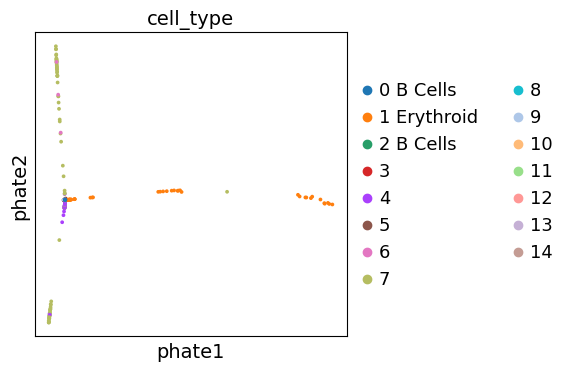

In [178]:
sc.external.pl.phate(adata_integrated,color="cell_type",color_map="tab20",return_fig=True).savefig('./plots/phate.pdf', bbox_inches='tight')